In [30]:
from scipy import integrate, constants, optimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
class Thermodynamic:
    def __init__(self, name: str):
        cols = ['Compound', '$\\Delta H_f$', '$S_f$', 'A', 'B', 'C', 'D', '$T_1$', '$T_2$']
        data = pd.read_csv('../../unit-04/ex-3/test-tab-04.csv', usecols=cols)
        compound_data = data.loc[data['Compound'] == name]
        self.Name = name
        self.Delta_H = float(compound_data['$\\Delta H_f$'].values[0])
        self.Delta_S = float(compound_data['$S_f$'].values[0]) * 1e-3
        self.A = float(compound_data['A'].values[0])
        self.B = float(compound_data['B'].values[0])
        self.C = float(compound_data['C'].values[0])
        self.D = float(compound_data['D'].values[0])
        self.T_min = float(compound_data['$T_1$'].values[0])
        self.T_max = float(compound_data['$T_2$'].values[0])

    def heat_capacity(self, T: float) -> float:
        return 1e-3 * (self.A + self.B * 1e-3 * T + self.C * 1e5 * np.pow(T, -2) + self.D * 1e-6 * np.pow(T, 2))

    def enthalpy(self, T: float):
        return self.Delta_H + integrate.quad(self.heat_capacity, 298, T)[0]

    def entropy(self, T: float):
        return self.Delta_S + integrate.quad(lambda x: self.heat_capacity(x) / x, 298, T)[0]

    def gibbs_energy(self, T: float):
        return self.enthalpy(T) - T * self.entropy(T)

In [32]:
def get_equilibrium_concentrations(species: list[str],
                                   Aeq: np.ndarray,
                                   feed: np.ndarray,
                                   Temp: float,
                                   n0: np.ndarray) -> np.ndarray:
    compounds = [Thermodynamic(name) for name in species]
    Gjo = np.array([compound.gibbs_energy(Temp) for compound in compounds])

    beq = np.array([np.sum(feed * Aeq[i]) for i in range(len(Aeq))])

    lgP = 1
    def func(nj: np.ndarray):
        Enj = np.sum(nj)
        G = np.sum(nj * (Gjo / constants.R / Temp + lgP + np.log(nj / Enj)))
        return G
    def ec1(n):
        'Equality constraint'
        return np.dot(Aeq, n) - beq

    def ic1(n):
        'Inequality constraint: all n>=0'
        return n
    
    X = optimize.fmin_slsqp(func, n0, f_eqcons=ec1, f_ieqcons=ic1, iter=100, acc=1e-6, full_output=1)
    return X[0]

In [33]:
T_min, T_max = 300, 1200
T = np.linspace(T_min, T_max, 5)

In [34]:
def proccess_reaction(species: list[str],
                      Aeq: np.ndarray) -> np.ndarray:
    rng = np.random.default_rng()
    feed = 5 * rng.random(4)
    print('feed: ', feed)
    n0 = [1, 1, 1, 1]
    C = get_equilibrium_concentrations(species, Aeq, feed, T[0], n0).reshape((1,-1))
    for Temp in T[1:]:
        conc = get_equilibrium_concentrations(species, Aeq, feed, Temp, n0).reshape((1, -1))
        C = np.concatenate((C, conc), axis=0)
    return C 

In [35]:
def draw_plot(C: np.ndarray, species: list[str], title: str):
    plt.figure(figsize=(5,5))
    for i in range(len(species)):
        plt.plot(T, C[:, i], label=species[i])
    plt.title(title)
    plt.xlabel("T, K")
    plt.ylabel("x, моль/л")
    plt.legend()
    plt.show()

### Паровой риформинг метана
Формула:
$$CH_4 + H_2O \rightleftharpoons CO + 3H_2$$

In [36]:
species = ["Methane", "Water", "Carbon Monoxide", "Hydrogen"]
Aeq = np.array(
    [
        [4,   2,   0,   2], # hydrogen balance
        [0,   1,   1,   0], # oxygen balance
        [1,   0,   1,   0], # carbon balance
#        CH4  H2O  CO   H2
    ])
C1 = proccess_reaction(species, Aeq)
print(C1)

feed:  [0.45999263 1.10891427 0.59914871 2.38745802]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.262285058791679
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.193364609499175
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1680823833147547
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1557886151163788
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1489937652146762
   

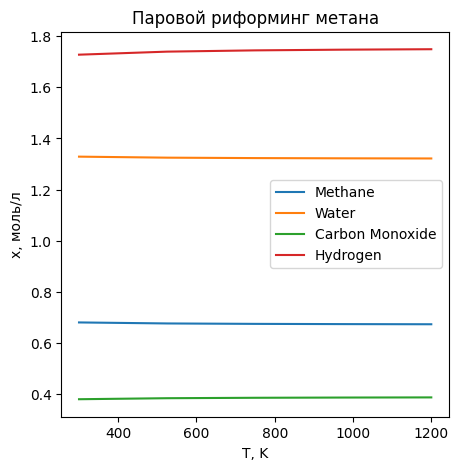

In [37]:
draw_plot(C1, species, "Паровой риформинг метана")

### Паровой риформинг пропана

Формула:
$$C_3H_8 + 3H_2O \rightleftharpoons 3CO + 7H_2$$

In [38]:
species = ["Propane", "Water", "Carbon Monoxide", "Hydrogen"]
Aeq = np.array(
    [
        [8,    2,    0,    2], # hydrogen balance
        [0,    1,    1,    0], # oxygen balance
        [3,    0,    1,    0], # carbon balance
#        C3H8  H2O   CO    H2
    ])
C2 = proccess_reaction(species, Aeq)
print(C2)

feed:  [0.51195803 1.34841701 4.01857368 4.98772653]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.2982490257415313
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.130606000757511
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.069185040589966
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.03960036671805
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.0236530761028884
     

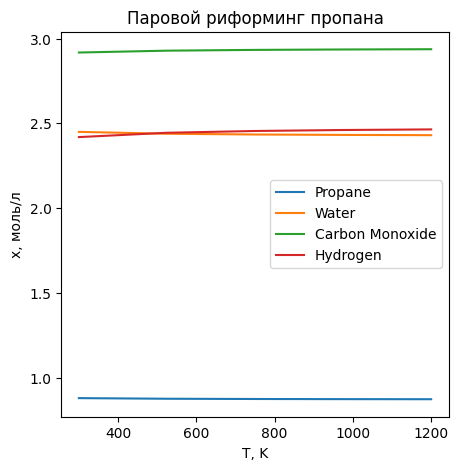

In [39]:
draw_plot(C2, species, "Паровой риформинг пропана")

### Паровой риформинг бутана

Формула:
$$C_4H_{10} + 4H_2O \rightleftharpoons 4CO + 9H_2$$

In [40]:
species = ["Propane", "Water", "Carbon Monoxide", "Hydrogen"]
Aeq = np.array(
    [
        [10,     2,      0,      2], # hydrogen balance
        [0,      1,      1,      0], # oxygen balance
        [4,      0,      1,      0], # carbon balance
#        C4H10   H2O     CO      H2
    ])
C3 = proccess_reaction(species, Aeq)
print(C3)

feed:  [0.28932866 4.63615247 2.37718644 1.12458113]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0758760587074425
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.857066270667687
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.7747902790274566
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.733439958764479
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.7095627168168
      

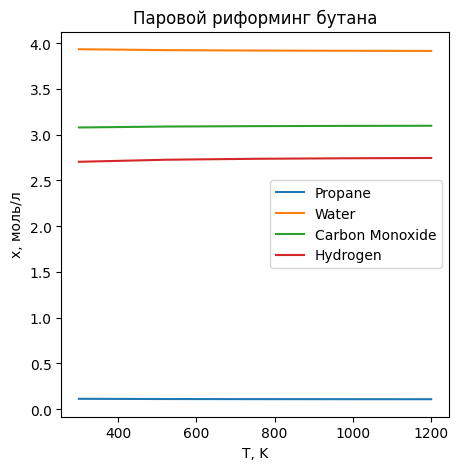

In [41]:
draw_plot(C3, species, "Паровой риформинг бутана")